In [1]:
# importing necessary packages

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, UpSampling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
batch_size = 128
img_size = (64, 64) # set the size for training data

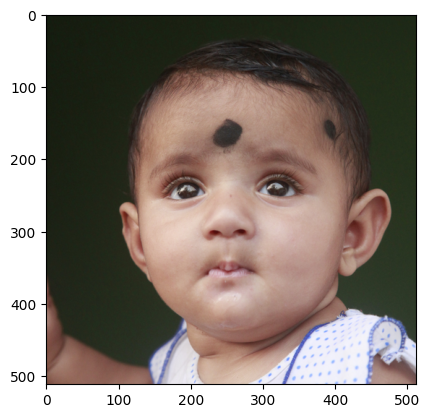

In [3]:
# plotting an example from dataset

path_to_images = 'E:/people_faces'
input_path = [os.path.join(path_to_images, x) for x in os.listdir(path_to_images)]
image = cv2.imread(input_path[np.random.randint(0, len(input_path))])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

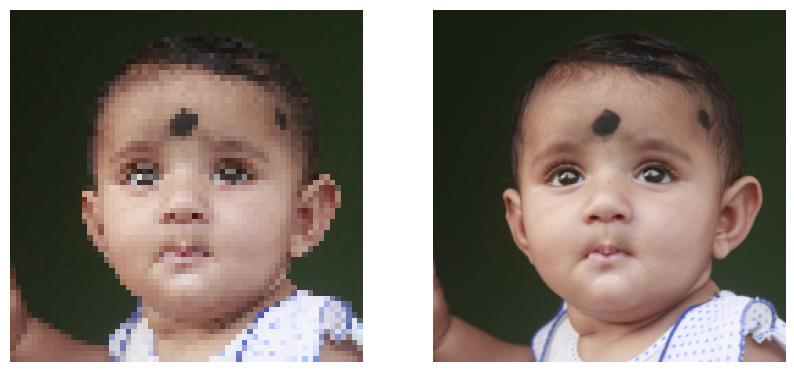

In [4]:
# comparing the low-res image (which will be used for training) and high-res image (target value)

plt.figure(figsize=(10,10))
plt.subplot(121)
low_res = cv2.resize(image, dsize=img_size)
plt.imshow(low_res)
plt.axis('off')
plt.subplot(122)
high_res = cv2.resize(image, dsize=tuple(np.multiply(img_size, 4)))
plt.imshow(high_res)
plt.axis('off')
plt.show()

In [5]:
# building the dataset class

class FacesDataset(tf.keras.utils.Sequence):    
    def __init__(self, batch_size, img_size, input_img_paths, output_img_paths):
        super(FacesDataset, self).__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.output_img_paths = output_img_paths

    def __len__(self):
        return len(self.output_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_output_img_paths = self.output_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + tuple(np.multiply(self.img_size, 4)) + (3,), dtype="float32")
        for j, path in enumerate(batch_output_img_paths):
            img = load_img(path, target_size=tuple(np.multiply(self.img_size, 4)))
            y[j] = img
            
        return x/255, y/255
    
    def on_epoch_end(self):
        self.input_img_paths, self.output_img_paths = shuffle(self.input_img_paths, self.output_img_paths)

In [6]:
# splitting the dataset into train, validation and test datasets

random.Random(69).shuffle(input_path)

train_input_imgs = input_path[:-int(len(input_path)*0.2)]
train_output_imgs = input_path[:-int(len(input_path)*0.2)]

val_input_imgs = input_path[-int(len(input_path)*0.2):-int(len(input_path)*0.1)]
val_output_imgs = input_path[-int(len(input_path)*0.2):-int(len(input_path)*0.1)]

test_input_imgs = input_path[-int(len(input_path)*0.1):]
test_output_imgs = input_path[-int(len(input_path)*0.1):]

print(len(train_input_imgs), len(train_output_imgs))
print(len(val_input_imgs), len(val_output_imgs))
print(len(test_input_imgs), len(test_output_imgs))

41601 41601
5200 5200
5200 5200


In [7]:
train_imgs = FacesDataset(batch_size, img_size, train_input_imgs, train_output_imgs)
val_imgs = FacesDataset(batch_size, img_size, val_input_imgs, val_output_imgs)
test_imgs = FacesDataset(batch_size, img_size, test_input_imgs, test_output_imgs)

In [9]:
# building model with combination of layers - conv2d + maxpooling2d and conv2dtranspose + upsampling2d

input = Input(shape=img_size + (3,))

x = Conv2D(32, (3, 3), padding="same")(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(32, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Activation('relu')(x)

output = Conv2D(3, (3, 3), padding="same", activation="sigmoid")(x)

model = Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 256)         │              

 Total params: 1,370,499 (5.23 MB)

 Trainable params: 1,368,579 (5.22 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
# although the 'mse' loss function is fit for current problem as it always shows low loss value, it's not good decision because it calculates
# the difference between two pixels which are closely similar. I need to differ the images more strictly, that's why I have used the ssim loss function
# that counts the ssim index (higher value depends on similarity between two images in brightness, contrast and structure). Higher index higher similarity,
# so for losses I need to subtract this value from 1

def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [11]:
model.compile(optimizer='adam', loss=SSIMLoss, metrics=['accuracy'])
callbacks = [EarlyStopping(patience=1)] # stopping the training when the val_loss starts to increase
history = model.fit(train_imgs, epochs=10, validation_data=val_imgs, callbacks=callbacks)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1417s 4s/step - accuracy: 0.7953 - loss: 0.3955 - val_accuracy: 0.8395 - val_loss: 0.4240
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1385s 4s/step - accuracy: 0.8741 - loss: 0.2874 - val_accuracy: 0.7986 - val_loss: 0.2935
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1386s 4s/step - accuracy: 0.8887 - loss: 0.2705 - val_accuracy: 0.8756 - val_loss: 0.2682
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1381s 4s/step - accuracy: 0.8916 - loss: 0.2631 - val_accuracy: 0.8670 - val_loss: 0.2636
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1387s 4s/step - accuracy: 0.8945 - loss: 0.2569 - val_accuracy: 0.8781 - val_loss: 0.2584
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1375s 4s/step - accuracy: 0.8981 - loss: 0.2531 - val_accuracy: 0.8810 - val_loss: 0.2551
Epoch 7/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1382s 4s/step - accuracy: 0.8996 - loss: 0.2492 - val_accuracy: 0.8956 - val_loss: 0.2511
Epoch 8/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1382s 4s/step - accuracy: 0.9032 - loss: 0.2466 - 

In [14]:
model.save_weights('best_model.weights.h5')

In [30]:
model.evaluate(test_imgs)

40/40 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.8741 - loss: 0.2534


[0.2540155351161957, 0.8752405047416687]

In [33]:
test_pred = model.predict(test_imgs[0][0][:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step


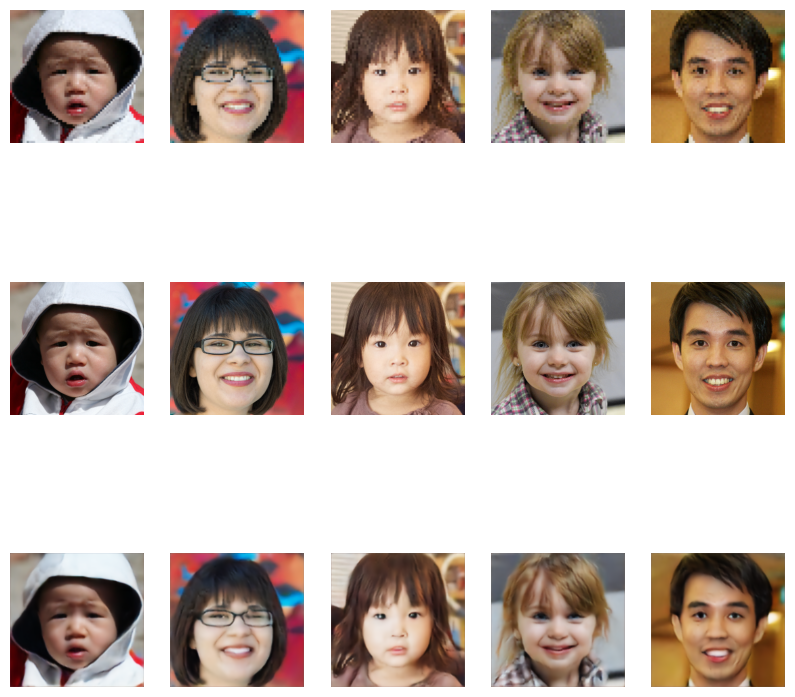

In [41]:
# plotting the input images with resolution 64x64, target images with resolution 256x256 and predicted images 256x256

fig, axes = plt.subplots(3, 5, figsize=(10, 10))

rand_samples = np.random.randint(0, len(test_imgs[0][0][:]), 5)
for i in range(5):
    axes[0, i].imshow(test_imgs[0][0][rand_samples[i]])
    axes[0, i].axis('off')

for i in range(5):
    axes[1, i].imshow(test_imgs[0][1][rand_samples[i]])
    axes[1, i].axis('off')

for i in range(5):
    axes[2, i].imshow(test_pred[rand_samples[i]])
    axes[2, i].axis('off')

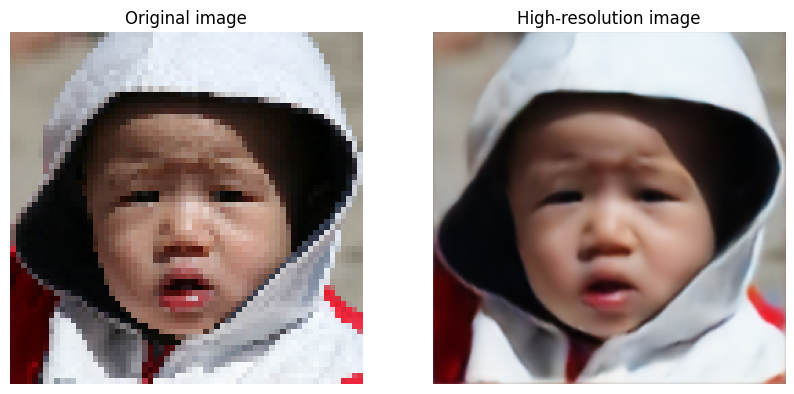

In [42]:
idx = 0

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(test_imgs[0][0][rand_samples[idx]])
plt.title('Original image')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_pred[rand_samples[idx]])
plt.title('High-resolution image')
plt.axis('off')
plt.show()

#### As a result, despite the fact that loss value is not as desirable as I expected, the output images look good, although some small structures on the images, such as teeth or eyes, are not generated perfectly.